In [117]:
import shutil
from itertools import compress
import glob #Модуль glob находит все пути, совпадающие с заданным шаблоном в соответствии с правилами, используемыми оболочкой Unix

import os
from PIL import Image
import torch
from img2vec_pytorch import Img2Vec #картинки в вектора - модуль с предобученными моделями, который нам выдаёт как раз эмебединги для кластеризации, классификации и т.д.
from tqdm import tqdm #progressbar

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.vq import kmeans2
import numpy as np

In [118]:
def read_images_from_directory(image_directory: str) -> list:
    """
    Reads all images from the given directory and returns a list of image paths.
    :param image_directory: The directory where the images are stored.
    :return: A list of image paths.
    """
    list_of_images = []
    image_extensions = ("*.gif", "*.png", "*.jpg", "*.jpeg")
    for ext in image_extensions:
        list_of_images.extend(glob.glob(os.path.join(image_directory, ext)))
    print(f"Images found: {len(list_of_images)}")
    return list_of_images

In [119]:
def read_with_pil(list_of_images: list, resize=True) -> list:
    """
    Reads a list of images using PIL and returns a list of PIL images.
    :param list_of_images: List of image paths.
    :param resize: If True, resize the image to 512x512. Defaults to True.
    :return: A list of PIL images.
    """
    print("Reading images...")
    pil_images = []
    for img_path in tqdm(list_of_images):
        img = Image.open(img_path).convert("RGB")
        if resize:
            img.thumbnail((512, 512))
        pil_images.append(img)
    print("Image reading done!")
    return pil_images

In [120]:
def save_embeddings(tensor, path="embeddings.pt"):
    """
    Saves the tensor embeddings to a file.
    :param tensor: The tensor to be saved.
    :param path: The path where the tensor should be saved. Defaults to "embeddings.pt".
    """
    torch.save(tensor, path)
    print(f"Embeddings are saved to {path}")


In [122]:
def load_from_embeddings(embedding_path):
    """
    Loads embeddings from the specified path.
    :param embedding_path: The path of the embeddings file.
    :return: The loaded embeddings tensor.
    """
    vec = torch.load(embedding_path)
    print("Embeddings loaded from folder.")
    if vec.dim() > 2:
        vec = torch.squeeze(vec)
    return vec

In [123]:
def create_image_grid(label_images, project_name, label_number):
    """
    Creates a grid of images with labels and saves it to a file.
    :param label_images: List of labeled images.
    :param project_name: The name of the project.
    :param label_number: The label number.
    """

    for i in range(len(label_images)):
        if i >= 9:
            break
        image = label_images[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image, cmap="gray", interpolation="none")
        plt.title(f"Class: {label_number}")
        plt.axis("off")
        plt.savefig(f"./clusters/{project_name}/cluster_{label_number}.png", dpi=300)

In [124]:
images = read_images_from_directory(r'C:/Users/Анна/Desktop/APPOPLEXY/Lesions/Lesions/imgs')
pil_images = read_with_pil(images)

Images found: 2230
Reading images...


100%|██████████| 2230/2230 [00:10<00:00, 208.39it/s]

Image reading done!


In [94]:
#https://github.com/christiansafka/img2vec
#сейчас используется ResNet-18
#длин возвращаемого вектора 512
img2vec = Img2Vec(cuda=False) #"Img2Vec is running on CPU..." cuda=True - on GPU
#img2vec = Img2Vec(cuda=False, model="efficientnet_b1")
embedding = img2vec.get_vec(pil_images[:10], tensor=True)
print("Img2Vec process done.")


c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Img2Vec process done.


In [95]:
embedding

tensor([[[[1.7807]],

         [[1.2749]],

         [[0.3812]],

         ...,

         [[0.0286]],

         [[0.1757]],

         [[1.1093]]],


        [[[0.4069]],

         [[1.1831]],

         [[0.5641]],

         ...,

         [[0.0060]],

         [[0.1901]],

         [[1.2130]]],


        [[[0.0470]],

         [[1.1783]],

         [[0.8894]],

         ...,

         [[0.1288]],

         [[0.0000]],

         [[0.6328]]],


        ...,


        [[[0.8551]],

         [[1.2874]],

         [[0.1147]],

         ...,

         [[0.7188]],

         [[0.0057]],

         [[0.4020]]],


        [[[0.7016]],

         [[1.9432]],

         [[0.3146]],

         ...,

         [[1.0365]],

         [[0.0000]],

         [[0.1201]]],


        [[[0.2956]],

         [[2.0468]],

         [[0.4898]],

         ...,

         [[1.0870]],

         [[0.0106]],

         [[0.2539]]]])

In [125]:
#сделаем mini batches
from torch.utils.data import DataLoader
from random import choice

#img2vec = Img2Vec(cuda=False, model="efficientnet_b1")
img2vec = Img2Vec(cuda=False)
embeddings = torch.empty(0)
for i in range(0, len(pil_images), 10):
    batch = pil_images[i:i+10]
    embeddings = torch.cat((embeddings, img2vec.get_vec(batch, tensor=True)), 0)
    

c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [127]:
embeddings[0]

tensor([[[8.4291e-01]],

        [[6.7497e-01]],

        [[3.8173e-01]],

        [[1.8333e+00]],

        [[1.2397e+00]],

        [[0.0000e+00]],

        [[7.1868e-01]],

        [[1.0234e+00]],

        [[2.8061e-02]],

        [[1.1196e-01]],

        [[1.5855e-02]],

        [[2.3911e-01]],

        [[1.3944e-01]],

        [[1.0127e+00]],

        [[9.0730e-01]],

        [[8.9642e-02]],

        [[6.5135e-01]],

        [[6.3083e-02]],

        [[6.4433e-01]],

        [[8.8732e-01]],

        [[8.0518e-01]],

        [[1.3276e-02]],

        [[5.1004e-01]],

        [[3.5409e-02]],

        [[1.4114e+00]],

        [[3.5159e-02]],

        [[3.2624e-01]],

        [[6.8982e-01]],

        [[0.0000e+00]],

        [[4.8544e-02]],

        [[1.3068e+00]],

        [[5.1478e-01]],

        [[3.7954e-01]],

        [[1.1237e+00]],

        [[1.2776e+00]],

        [[0.0000e+00]],

        [[3.1994e-02]],

        [[2.5221e-02]],

        [[2.6950e-02]],

        [[7.6471e-01]],



In [168]:
def calculate_pca(embeddings, dim=16):
    print("Calculating PCA")
    pca = PCA(n_components=dim)
    pca_embeddings = pca.fit_transform(embeddings.squeeze())
    print("PCA calculating done!")
    return pca_embeddings



pca_embeddings = calculate_pca(embeddings) #principal component analysis


Calculating PCA
PCA calculating done!


In [129]:
def calculate_kmeans(embeddings, k):
    print("KMeans processing...")
    centroid, labels = kmeans2(data=embeddings, k=k, minit="points")
    counts = np.bincount(labels)
    print("Kmeans done!")
    return centroid, labels
    
centroids, labels = calculate_kmeans(pca_embeddings, k=cluster_range)

KMeans processing...
Kmeans done!


c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

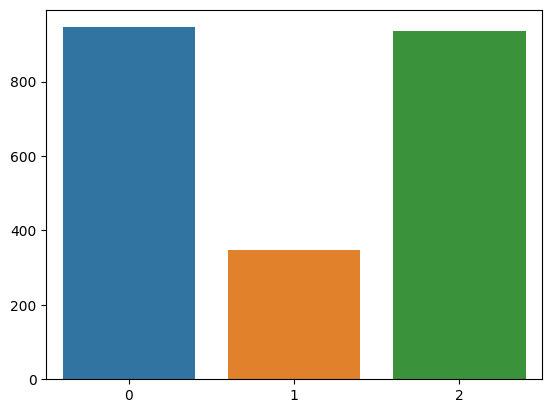

In [130]:
import seaborn as sns
unique, counts = np.unique(labels, return_counts=True)
sns.barplot(x=unique, y=counts)

KMeans processing...
Kmeans done!


c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

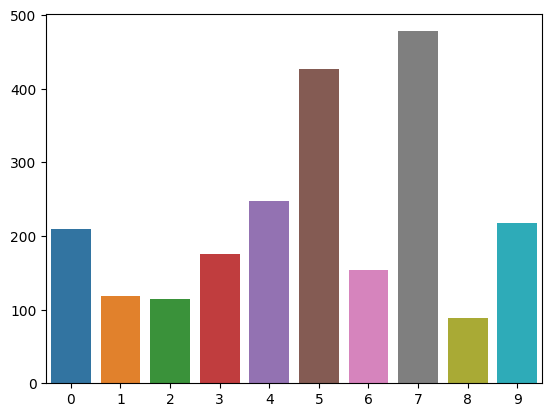

In [215]:
def calculate_kmeans(embeddings, k):
    print("KMeans processing...")
    centroid, labels = kmeans2(data=embeddings, k=k, minit="points")
    counts = np.bincount(labels)
    print("Kmeans done!")
    return centroid, labels
    
centroids, labels = calculate_kmeans(pca_embeddings, k=10)
unique, counts = np.unique(labels, return_counts=True)
sns.barplot(x=unique, y=counts)

c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

<Axes: >

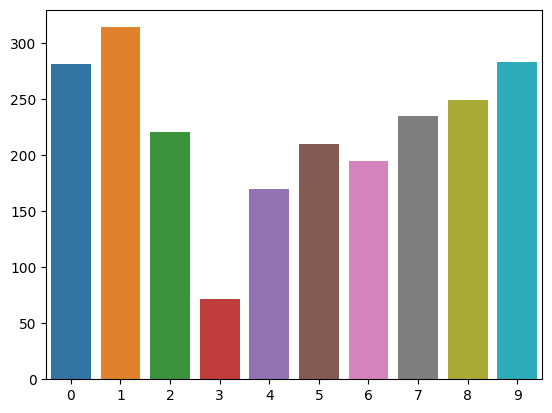

In [228]:
from  sklearn.cluster import KMeans
cl = KMeans( n_clusters=10, init='k-means++',random_state=None).fit(pca_embeddings)
unique, counts = np.unique(cl.labels_, return_counts=True)
sns.barplot(x=unique, y=counts)

In [202]:
from  sklearn.cluster import AgglomerativeClustering
cl = AgglomerativeClustering().fit(pca_embeddings)
labels = cl.labels_
cl.get_metadata_routing()

{}

In [191]:
pca_embeddings

array([[-6.25293547,  1.09774824, -2.61578679, ...,  0.0685047 ,
         1.38956973,  1.13824235],
       [ 8.74897763, -5.88837507, -0.1469696 , ..., -1.09348356,
         1.18518785, -0.08578761],
       [ 4.36225047,  7.06416014, -2.86157603, ..., -0.20777988,
         0.63262537,  1.11822672],
       ...,
       [-6.59896567,  2.94055217, -0.99409569, ...,  2.45659581,
        -1.24130239, -1.26039428],
       [ 6.4206004 , -4.40697728, -1.50418681, ...,  0.8037721 ,
         0.34578654,  0.27251129],
       [-6.23947974,  1.0253444 , -1.09271427, ..., -0.97753931,
         0.90399562, -1.02605169]])

In [178]:
from sklearn.cluster import DBSCAN #Density-based spatial clustering of applications with noise
db = DBSCAN(eps=0.00001, min_samples=50).fit(pca_embeddings)
labels = db.labels_

[-1] [2230]


c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\torch_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

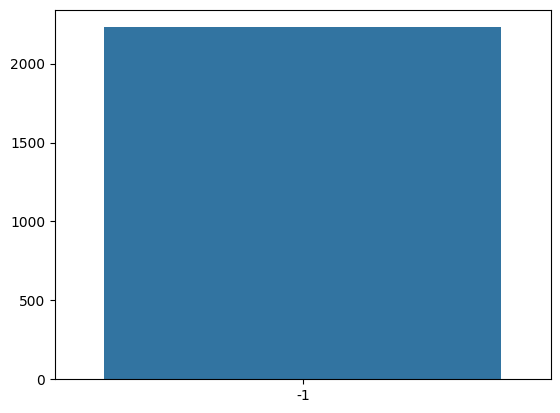

In [179]:
unique, counts = np.unique(labels, return_counts=True)
print(unique, counts)
sns.barplot(x=unique, y=counts)

### Classification